# Combined datasets

<table style="border: 0; border-collapse: collapse; border-spacing: 0;">
  <tr>
    <td style="width:50%; border: none;">
    Problem: Data analysis frequently necessitates the manipulation of datasets scattered across various tables, such as those found in pandas DataFrames or SQL databases. The integration and examination of this distributed data mandate the execution of table joins via shared fields. Although this operation is not inherently difficult, it can become cumbersome when the datasets are extensive or when numerous tables are involved.
    <p><p>
    See more in discussion: <a href="https://github.com/i2mint/tabled/discussions/3">https://github.com/i2mint/tabled/discussions/3</a>
    </td>
    <td style="border: none;">
      <img src="https://github.com/i2mint/tabled/assets/1906276/37dd2e30-3792-4d0b-94a5-c48e83986061" width=320 alt="Venn diagram of fields">
    </td>
  </tr>
</table>

## Making get_table_join

We want to make this:

```python

```

In [15]:
from typing import Callable, Iterable, Mapping
import pandas as pd

In [16]:
def combined_table(tables, fields):
    """
    Get table with requested `fields`, computed by joining relevant tables 
    of `tables`.
    """
    resolution_sequence_ = resolution_sequence(tables, fields)
    join_view = compute_join_resolution(resolution_sequence_, tables)
    return join_view

# where...

def resolution_sequence(field_sets: dict, fields_to_cover: Iterable) -> list:
    """
    Returns the list of join operations that, when carried out, 
    cover the given fields.
    
    :param field_sets: A mapping of table names to sets of their fields.
    :param fields: The fields to cover.
    """

def compute_join_resolution(
        resolution_sequence: Iterable, tables: Mapping[str, pd.DataFrame]
    ) -> pd.DataFrame:
    """
    Carries `resolution_sequence` join operations out with tables taken 
    from `tables`.
    
    :param resolution_sequence: An iterable of join operations to carry out. 
        Each join operation is either a table name (str) or a JoinWith object.
        If it's a JoinWith object, it's assumed that the table has already 
        been joined and the fields to remove are in the `remove` 
        attribute of the object.
    :param tables: A mapping of table names to tables (pd.DataFrame)
    """

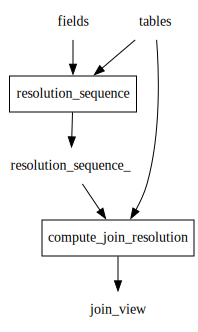

In [17]:
__import__('meshed').code_to_dag(combined_table).dot_digraph()



In [18]:
from dataclasses import dataclass


tables = {
    "A": pd.DataFrame({'b': [1, 2, 3, 33], 'c': [4, 5, 6, 66]}),
    "B": pd.DataFrame(
        {'b': [1, 2, 3], 'a': [4, 5, 6], 'd': [7, 8, 9], 
         'e': [10, 11, 12], 'f': [13, 14, 15]}
    ),
    "C": pd.DataFrame({'f': [13, 14, 15], 'g': [4, 5, 6]}),
    "D": pd.DataFrame(
        {'d': [7, 8, 77], 'e': [10, 11, 77], 'h': [7, 8, 9], 'i': [1, 2, 3]}
    ),
    "E": pd.DataFrame({'i': [1, 2, 3], 'j': [4, 5, 6]})
}

field_sets = {table_id: set(df.columns) for table_id, df in tables.items()}
assert field_sets == {
    "A": {'b', 'c'},
    "B": {'b', 'a', 'd', 'e', 'f'},
    "C": {'f', 'g'},
    "D": {'d', 'e', 'h', 'i'},
    "E": {'i', 'j'}
}

@dataclass
class JoinWith:
    table_key: str
    remove: list = None

fields_to_cover = ['b', 'g', 'j']
expected_join_resolution = [
    'B',
    JoinWith('C', remove=['a', 'f']),
    JoinWith('D', remove=['d', 'e', 'h']),
    JoinWith('E', remove=['i'])
]
expected_result = pd.DataFrame({
    'b': [1, 2],
    'g': [4, 5],
    'j': [4, 5]
})


The tests would be

In [19]:
def test_join_resolution(
        join_resolution: Callable,
        *,
        field_sets: dict = field_sets, 
        fields_to_cover: Iterable = fields_to_cover,
        expected_join_resolution: list = expected_join_resolution,
    ):
    assert join_resolution(field_sets, fields_to_cover) == expected_join_resolution

def test_compute_join_resolution(
    compute_join_resolution: Callable, 
    *,
    resolution_sequence: Iterable = expected_join_resolution,
    tables: Mapping[str, pd.DataFrame] = tables,
    expected_result: pd.DataFrame = expected_result,   
):
    result = compute_join_resolution(resolution_sequence, tables)
    assert tables_are_equal(result, expected_result)


def tables_are_equal(
        t1, t2, *, ignore_index=True, sort_index=True, sort_columns=True
    ):
    """
    Compare two tables for equality, ignoring (by default) index and column order.
    """
    if ignore_index:
        t1 = t1.reset_index(drop=True)
        t2 = t2.reset_index(drop=True)
    elif sort_index:
        t1 = t1.sort_index(axis=1)
        t2 = t2.sort_index(axis=1)
    if sort_columns:
        t1 = t1.sort_index(axis=0)
        t2 = t2.sort_index(axis=0)
    return t1.equals(t2)


In [21]:
def ensure_join_op(obj):
    if not isinstance(obj, JoinWith):
        return JoinWith(obj)
    return obj
        

def compute_join_resolution(
        resolution_sequence: Iterable, tables: Mapping[str, pd.DataFrame]
    ) -> pd.DataFrame:
    """
    Carries `resolution_sequence` join operations out with tables taken from `tables`.
    
    :param resolution_sequence: An iterable of join operations to carry out. 
        Each join operation is either a table name (str) or a JoinWith object.
        If it's a JoinWith object, it's assumed that the table has already been joined
        and the fields to remove are in the `remove` attribute of the object.
    :param tables: A mapping of table names to tables (pd.DataFrame)
    """
    join_ops = map(ensure_join_op, resolution_sequence)
    table_key = next(join_ops).table_key
    joined = tables[table_key]
    for join_op in join_ops:
        table = tables[join_op.table_key]
        joined = joined.merge(table, how='inner')
        if join_op.remove:
            remove_cols = set(join_op.remove) & set(joined.columns)
            joined = joined.drop(columns=remove_cols)
    return joined

# from tabled.multi import compute_join_resolution, ensure_join_op

# test_compute_join_resolution(compute_join_resolution)

**TODO: Implement the join_resolution function -- possibly using the [intersection_graph](https://github.com/i2mint/tabled/blob/282784fc4113b47371ce59a6e14ad2566d7f2abb/tabled/util.py#L25) function on field_sets to help**

## Getting the minimum connected set covering

In [22]:
from tabled.util import (
    intersection_graph, invert_labeled_collection, map_values, breadth_first_traversal
)

labeled_sets = {
    "A": {'b', 'c'},
    "B": {'b', 'a', 'd', 'e', 'f'},
    "C": {'f', 'g'},
    "D": {'d', 'e', 'h', 'i'},
    "E": {'i', 'j'}
}

sets_containing_elements = invert_labeled_collection(labeled_sets, values_container=set)
intersections = intersection_graph(labeled_sets, edge_labels='elements')
graph = {k: list(v) for k, v in intersections.items()}

(
    'labeled_sets', labeled_sets, 
    'sets_containing_elements', sets_containing_elements, 
    'intersections', intersections, 
    'graph', graph
)


('labeled_sets',
 {'A': {'b', 'c'},
  'B': {'a', 'b', 'd', 'e', 'f'},
  'C': {'f', 'g'},
  'D': {'d', 'e', 'h', 'i'},
  'E': {'i', 'j'}},
 'sets_containing_elements',
 {'b': {'A', 'B'},
  'c': {'A'},
  'f': {'B', 'C'},
  'a': {'B'},
  'd': {'B', 'D'},
  'e': {'B', 'D'},
  'g': {'C'},
  'h': {'D'},
  'i': {'D', 'E'},
  'j': {'E'}},
 'intersections',
 {'A': {'B': {'b'}},
  'B': {'A': {'b'}, 'C': {'f'}, 'D': {'d', 'e'}},
  'C': {'B': {'f'}},
  'D': {'B': {'d', 'e'}, 'E': {'i'}},
  'E': {'D': {'i'}}},
 'graph',
 {'A': ['B'], 'B': ['A', 'C', 'D'], 'C': ['B'], 'D': ['B', 'E'], 'E': ['D']})

<img src="https://github.com/i2mint/tabled/assets/1906276/37dd2e30-3792-4d0b-94a5-c48e83986061" width=320 alt="Venn diagram of fields">

In [23]:
from typing import KT, VT

def minimum_covering_tree(
        graph: Mapping[KT, Iterable], 
        target_subset: Iterable[VT],
        start_node=None, 
    ):
    """
    
    """
    if start_node is None:  # if not start_node is given
        start_node = next(iter(graph))  # take the first node
    target_sub_set = set(target_subset)
    traversal = breadth_first_traversal(graph, 'B', yield_edges=True)

    edges = list()
    covered = set()

    for set_label_1, set_label_2 in traversal:
        if target_sub_set.issubset(covered):
            break
        covered |= labeled_sets[set_label_1] | labeled_sets[set_label_2]
        edges.append((set_label_1, set_label_2))

    return edges


minimum_covering_tree(graph, {'b', 'g', 'j'}, 'B')
    


[('B', 'A'), ('B', 'C'), ('B', 'D'), ('D', 'E')]

In [24]:
target_sub_set = {'b', 'g', 'j'}

* for each leaf edge, recursively remove the leaf edge iff none of the lost associated elements are in target subset
* now go through each edge (possible starting with leaf), yielding `Join(table_id)` for each of the two `table_id` of the edge (as long as it hasn't been joined before)
* now go through the resulting `Join` sequence and weave `Remove` commands in them with the following rule: Remove field if the associated elements (fields) are neither in target field nor is the field associated with any of the later Joins.

In [26]:
from typing import List, Tuple, Set

def get_leaf_edges(
        graph: Mapping[KT, Iterable[VT]], 
        target_subset: Set[VT],
        start_node: KT = None
    ) -> List[Tuple[KT, KT]]:
    if start_node is None:  # if no start_node is given
        start_node = next(iter(graph))  # take the first node
    
    traversal = breadth_first_traversal(graph, start_node, yield_edges=True)

    edges = []  # List to store edges of the covering tree
    covered = set()  # Set to store covered elements
    node_connections = {}  # Dictionary to track the number of connections for each node

    for node1, node2 in traversal:
        if target_subset.issubset(covered):
            break

        # Update covered elements and the number of connections for each node
        covered |= labeled_sets[node1] | labeled_sets[node2]
        node_connections[node1] = node_connections.get(node1, 0) + 1
        node_connections[node2] = node_connections.get(node2, 0) + 1
        edges.append((node1, node2))

    # Filter edges to return only those that lead to a node with one connection
    leaf_edges = [edge for edge in edges if node_connections[edge[1]] == 1]

    return leaf_edges

leaf_edges = get_leaf_edges(graph, {'b', 'g', 'j'}, 'B')
leaf_edges

[('B', 'A'), ('B', 'C'), ('D', 'E')]

In [27]:
def update_leaf_edges_after_removal(
    graph: Mapping[str, List[str]],
    labeled_sets: Mapping[str, Set[str]],
    target_sub_set: Set[str],
    current_leaf_edges: List[Tuple[str, str]]
) -> List[Tuple[str, str]]:
    """
    Update the list of leaf edges after removing an edge, ensuring that the resulting
    leaf edges do not lead to the loss of any elements in the target subset.

    :param graph: The graph represented as an adjacency list.
    :param labeled_sets: The sets of elements labeled by nodes.
    :param target_subset: The target subset of elements that must remain covered.
    :param current_leaf_edges: The current list of leaf edges.
    :return: An updated list of leaf edges.
    """
    new_leaf_edges = []
    for node1, node2 in current_leaf_edges:
        # Use symmetric difference to consider the edge as undirected
        unique_elements = ((labeled_sets[node1] - labeled_sets[node2]) | 
                           (labeled_sets[node2] - labeled_sets[node1])) & target_sub_set
        
        # Check if the unique elements do not include any from the target subset
        if not unique_elements:
            # Remove the edge from the graph
            graph[node1].remove(node2)
            graph[node2].remove(node1)
        else:
            # If the edge cannot be removed, add it to the new list of leaf edges
            new_leaf_edges.append((node1, node2))

    # Recalculate the leaf edges after removals
    for node, neighbors in graph.items():
        if len(neighbors) == 1:  # If the node is now a leaf node
            neighbor = neighbors[0]
            if (node, neighbor) not in new_leaf_edges and (neighbor, node) not in new_leaf_edges:
                new_leaf_edges.append((node, neighbor))

    return new_leaf_edges

# Create a copy of the original graph to modify
modifiable_graph = {node: neighbors[:] for node, neighbors in graph.items()}

# Update the leaf edges considering the target subset
updated_leaf_edges = update_leaf_edges_after_removal(
    modifiable_graph, labeled_sets, target_sub_set, leaf_edges)

# The updated graph and leaf edges
(modifiable_graph, updated_leaf_edges)

({'A': [], 'B': ['C', 'D'], 'C': ['B'], 'D': ['B', 'E'], 'E': ['D']},
 [('B', 'C'), ('D', 'E')])

In [30]:
from typing import List, Set, Tuple, Dict

class Join:
    def __init__(self, table_id: str, remove: List[str] = None):
        self.table_id = table_id
        self.remove = remove or []

    def __repr__(self):
        remove_str = f", remove={self.remove}" if self.remove else ""
        return f"Join('{self.table_id}'{remove_str})"

def determine_remove_fields(
    labeled_sets: Dict[str, Set[str]],
    target_sub_set: Set[str],
    joined_tables: Set[str],
    current_table: str
) -> List[str]:
    """
    Determine which fields should be removed for a given table

    :param labeled_sets: The sets of elements labeled by nodes
    :param target_sub_set: The target subset of elements that must remain covered
    :param joined_tables: The set of tables that have been or will be joined
    :param current_table: The current table being processed
    :return: A list of fields to remove
    """
    fields = labeled_sets[current_table]
    removable_fields = [
        field for field in fields
        if field not in target_sub_set
        and all(field not in labeled_sets[table] for table in joined_tables if table != current_table)
    ]
    return removable_fields


In [31]:
def generate_join_sequence(
    leaf_edges: List[Tuple[str, str]],
    labeled_sets: Dict[str, Set[str]],
    target_sub_set: Set[str]
) -> List[Join]:
    """
    Generate a sequence of joins with remove commands based on leaf edges

    :param leaf_edges: The list of leaf edges to process
    :param labeled_sets: The sets of elements labeled by nodes
    :param target_sub_set: The target subset of elements that must remain covered
    :return: A list of Join operations
    """
    joins = []  # Stores the sequence of joins
    joined_tables = set()  # Tracks tables that have been joined
    future_joins = {node for edge in leaf_edges for node in edge}  # Tracks all future joins

    # Start with the first node of the first edge without removals
    first_node = leaf_edges[0][0]
    first_node_remove_fields = determine_remove_fields(
        labeled_sets, target_sub_set, future_joins, first_node
    )
    joins.append(first_node)

    for node1, node2 in leaf_edges:
        for node in (node1, node2):
            if node not in joined_tables:
                # Determine the fields to remove considering future joins
                remove_fields = determine_remove_fields(
                    labeled_sets, target_sub_set, future_joins, node
                )
                if node == first_node:
                    remove_fields = first_node_remove_fields
                elif node in leaf_edges[0]:  # If the node is to join with the first node
                    remove_fields.extend(first_node_remove_fields)  # Append remove_fields from the first node

                if node != first_node:
                    joins.append(Join(node, remove_fields))
                # Update the tracking sets
                joined_tables.add(node)
                future_joins.remove(node)

    return joins

# Using the leaf edges and labeled sets from the previous example
target_sub_set = {'b', 'g', 'j'}
leaf_edges = [('B', 'C'), ('D', 'E')]

# Generate the join sequence
join_sequence = generate_join_sequence(leaf_edges, labeled_sets, target_sub_set)
print(join_sequence)

['B', Join('C', remove=['f', 'a']), Join('D', remove=['h', 'd', 'e']), Join('E', remove=['i'])]


In [34]:
def ensure_join_op(obj):
    if not isinstance(obj, Join):
        return Join(obj)
    return obj
        

def compute_join_resolution(
        resolution_sequence: Iterable, tables: Mapping[str, pd.DataFrame]
    ) -> pd.DataFrame:
    """
    Carries `resolution_sequence` join operations out with tables taken from `tables`.
    
    :param resolution_sequence: An iterable of join operations to carry out. 
        Each join operation is either a table name (str) or a Join object.
        If it's a Join object, it's assumed that the table has already been joined
        and the fields to remove are in the `remove` attribute of the object.
    :param tables: A mapping of table names to tables (pd.DataFrame)
    """
    join_ops = map(ensure_join_op, resolution_sequence)
    table_key = next(join_ops).table_id
    joined = tables[table_key]
    for join_op in join_ops:
        table = tables[join_op.table_id]
        joined = joined.merge(table, how='inner')
        if join_op.remove:
            remove_cols = set(join_op.remove) & set(joined.columns)
            joined = joined.drop(columns=remove_cols)
    return joined

In [35]:
compute_join_resolution(join_sequence,tables)

,b,g,j
0,1,4,4
1,2,5,5


# WIP Scrap

In [166]:
import networkx as nx

def approximate_steiner_tree(graph, terminal_sets):
    # Flatten the set of terminal nodes
    terminal_nodes = set.union(*terminal_sets)

    # Create a complete graph of terminals with shortest path distances as weights
    metric_closure = nx.algorithms.tree.mst.metric_closure(graph, weight='weight')
    mst = nx.minimum_spanning_tree(metric_closure, weight='weight')
    
    # Map the tree back to the original graph
    steiner_tree = nx.Graph()
    for (u, v) in mst.edges():
        path = nx.shortest_path(graph, source=u, target=v, weight='weight')
        nx.add_path(steiner_tree, path)

    return steiner_tree


import networkx as nx

def find_terminals(labels, labels_to_cover):
    """Identify terminal nodes based on labels."""
    terminals = set()
    for node, node_labels in labels.items():
        if labels_to_cover.intersection(node_labels):
            terminals.add(node)
    return terminals

def construct_graph(adjacencies):
    """Construct a graph from adjacency list."""
    graph = nx.Graph()
    for node, neighbors in adjacencies.items():
        for neighbor in neighbors:
            graph.add_edge(node, neighbor)
    return graph

def construct_complete_graph(graph, terminals):
    """Construct a complete graph between terminal nodes with shortest path distances."""
    complete_graph = nx.Graph()
    for node1 in terminals:
        for node2 in terminals:
            if node1 != node2:
                distance = nx.shortest_path_length(graph, source=node1, target=node2)
                complete_graph.add_edge(node1, node2, weight=distance)
    return complete_graph

def steiner_tree_from_complete(complete_graph, terminals):
    """Find a Steiner tree from the complete graph."""
    mst = nx.minimum_spanning_tree(complete_graph, weight='weight')
    steiner_tree = nx.Graph()
    for (u, v) in mst.edges():
        path = nx.shortest_path(graph, source=u, target=v)
        nx.add_path(steiner_tree, path)
    return steiner_tree

# Input data
adjacencies = {'A': ['B'], 'B': ['A', 'C', 'D'], 'C': ['B'], 'D': ['B', 'E'], 'E': ['D']}
labels = {'A': {'b', 'c'}, 'B': {'a', 'b', 'd', 'e', 'f'}, 'C': {'f', 'g'}, 'D': {'d', 'e', 'h', 'i'}, 'E': {'i', 'j'}}
labels_to_cover = {'b', 'g', 'j'}

# Process
graph = construct_graph(adjacencies)
terminals = find_terminals(labels, labels_to_cover)
complete_graph = construct_complete_graph(graph, terminals)
steiner_tree = steiner_tree_from_complete(complete_graph, terminals)

# Result
tree_edges = list(steiner_tree.edges())
print(tree_edges)


[('C', 'B'), ('B', 'A'), ('B', 'D'), ('D', 'E')]


In [48]:
def test_join_resolution(
        join_resolution: Callable,
        *,
        field_sets: dict = field_sets, 
        fields_to_cover: Iterable = fields_to_cover,
        expected_join_resolution: list = expected_join_resolution,
    ):
    assert join_resolution(field_sets, fields_to_cover) == expected_join_resolution


# Given test data and expected results
field_sets = {
    "A": {'b', 'c'},
    "B": {'b', 'a', 'd', 'e', 'f'},
    "C": {'f', 'g'},
    "D": {'d', 'e', 'h', 'i'},
    "E": {'i', 'j'}
}
fields_to_cover = ['b', 'g', 'j']


def join_resolution(field_sets: dict, fields_to_cover: Iterable[str]) -> list:
    fields_to_cover = set(fields_to_cover)
    field_sets = field_sets.copy()
    resolution_sequence = []
    # Initialize covered fields with an empty set
    covered_fields = set()

    # Loop until we've covered all fields
    while not fields_to_cover.issubset(covered_fields):
        # Find the table that has the most uncovered fields to cover
        next_table = max(
            field_sets.keys(),
            key=lambda t: len(fields_to_cover.intersection(field_sets[t])) - len(covered_fields.intersection(field_sets[t])),
            default=None
        )

        if next_table is None:
            # If we can't find a next table, it means we can't cover the fields with the given field sets
            raise ValueError("Cannot cover all fields with the given field sets.")

        # Determine which fields from the new table we will need to remove after the join
        fields_to_remove = (covered_fields & field_sets[next_table]) - fields_to_cover

        # If this is not the first table, we create a JoinWith instance, otherwise, just add the table name
        if resolution_sequence:
            resolution_sequence.append(JoinWith(table_key=next_table, remove=list(fields_to_remove)))
        else:
            resolution_sequence.append(next_table)

        # Update covered fields
        covered_fields.update(field_sets[next_table])

        # Remove the used table from field_sets to prevent reusing it
        del field_sets[next_table]

    return resolution_sequence

# test_join_resolution(join_resolution)
join_resolution(field_sets, fields_to_cover)


['A', JoinWith(table_key='C', remove=[]), JoinWith(table_key='E', remove=[])]

In [53]:
# Given test data and expected results
field_sets = {
    "A": {'b', 'c'},
    "B": {'b', 'a', 'd', 'e', 'f'},
    "C": {'f', 'g'},
    "D": {'d', 'e', 'h', 'i'},
    "E": {'i', 'j'}
}
fields_to_cover = ['b', 'g', 'j']

def test_minimum_covering_intersections(
        minimum_covering_intersections: Callable,
        *,
        field_sets: dict = field_sets, 
        fields_to_cover: Iterable = fields_to_cover,
        expected_result: set = {('B', 'C'), ('B', 'D'), ('B', 'E')}
    ):
    assert minimum_covering_intersections(field_sets, fields_to_cover) == expected_result


def minimum_covering_intersections(field_sets, fields_to_cover):
    """Returns a set of set pairs that connect the elements of `fields_to_cover`.
    
    :param field_sets: A mapping of sets of field names
    :param fields_to_cover: A set of field names to cover
    :return: A set of set pairs that connect the elements of `fields_to_cover`
    
    The returned pairs are `(key_1, key_2)` pairs of keys of `field_sets`
    such that field_sets[key_1] & field_sets[key_2] is not empty.
    The union of all the sets in the pairs should cover `fields_to_cover`.
    """
    

from itertools import combinations

def minimum_covering_intersections(field_sets, fields_to_cover):
    fields_to_cover = set(fields_to_cover)  # Ensure we have a set to work with
    covering_pairs = set()
    covered_fields = set()

    # Go through all unique pairs of keys from field_sets
    for key1, key2 in combinations(field_sets.keys(), 2):
        intersection = field_sets[key1] & field_sets[key2]
        
        # Check if this pair covers any new fields that we need to cover
        newly_covered = intersection & fields_to_cover - covered_fields
        if newly_covered:
            covering_pairs.add((key1, key2))
            covered_fields.update(newly_covered)
            
        # If we've covered all fields, we can stop early
        if covered_fields == fields_to_cover:
            break

    return covering_pairs

minimum_covering_intersections(field_sets, fields_to_cover)


{('A', 'B')}

In [76]:
field_sets

{'A': {'b', 'c'},
 'B': {'a', 'b', 'd', 'e', 'f'},
 'C': {'f', 'g'},
 'D': {'d', 'e', 'h', 'i'},
 'E': {'i', 'j'}}

In [80]:
from tabled.util import intersection_graph

assert intersection_graph(field_sets) == {
    'A': {'B'}, 'B': {'A', 'C', 'D'}, 'C': {'B'}, 'D': {'B', 'E'}, 'E': {'D'}
}





In [88]:
from typing import Dict, Tuple, Set

def minimum_covering_intersections(field_sets: Dict[str, Set[str]], fields_to_cover: Set[str]) -> Set[Tuple[str, str]]:
    # Construct the intersection graph
    graph = intersection_graph(field_sets, edge_labels='elements')
    
    # Initialize variables to track covered fields and the pairs to return
    covered_fields = set()
    covering_pairs = set()

    # Function to perform Depth-First Search (DFS) on the graph
    def dfs(node, visited, component):
        visited.add(node)
        component.add(node)
        for neighbour in graph[node]:
            if neighbour not in visited:
                dfs(neighbour, visited, component)
                
    # Find all connected components in the graph
    visited = set()
    components = []
    for node in graph:
        if node not in visited:
            component = set()
            dfs(node, visited, component)
            components.append(component)
    
    # Find the minimum set of set pairs for each component
    for component in components:
        # Check if this component contains any of the fields we need to cover
        if any(field in covered_fields for node in component for field in field_sets[node]):
            # Perform a modified Prim's algorithm to find the minimum spanning tree that covers fields_to_cover
            mst_edges = set()  # This will store the edges of the minimum spanning tree
            component_fields_to_cover = {field for node in component for field in field_sets[node] if field in fields_to_cover}
            covered_in_component = set()
            available_edges = [(len(graph[node][neighbour]), node, neighbour) for node in component for neighbour in graph[node] if neighbour in component]
            sorted_edges = sorted(available_edges)
            
            while component_fields_to_cover - covered_in_component:
                # Select the edge with minimum weight (smallest intersection)
                _, node1, node2 = sorted_edges.pop(0)
                # Add this edge if it helps to cover more fields
                if field_sets[node1] & field_sets[node2] & fields_to_cover:
                    mst_edges.add((node1, node2))
                    covered_in_component.update(field_sets[node1] & field_sets[node2])
            
            # Add the edges of this minimum spanning tree to the covering pairs
            covering_pairs.update(mst_edges)
    
    # Make sure the pairs are in the correct order
    ordered_covering_pairs = {(min(pair), max(pair)) for pair in covering_pairs}
    
    return ordered_covering_pairs


field_sets = {'A': {'b', 'c'},
 'B': {'a', 'b', 'd', 'e', 'f'},
 'C': {'f', 'g'},
 'D': {'d', 'e', 'h', 'i'},
 'E': {'i', 'j'}}

fields_to_cover = ['b', 'g', 'j']

edges = minimum_covering_intersections(field_sets, fields_to_cover)
edges

set()

In [87]:
edges = minimum_covering_intersections(field_sets, fields_to_cover)
assert sorted(edges) == [('B', 'C'), ('B', 'D'), ('D', 'E')]

AssertionError: 

In [189]:
from typing import Iterable, Mapping
from dataclasses import dataclass
import pandas as pd

# Define the JoinWith dataclass
@dataclass
class JoinWith:
    table_key: str
    remove: list = None

# Define the function to find the join resolution
def join_resolution(field_sets: dict, fields_to_cover: Iterable[str]) -> list:
    fields_to_cover = set(fields_to_cover)  # Set of fields we need to cover
    join_sequence = []  # The output sequence of joins
    covered_fields = set()  # Fields covered by the join sequence so far

    # While there are fields left to cover, iterate
    while fields_to_cover:
        # Find the table that covers the most fields which are not yet covered
        next_table, next_fields = max(
            field_sets.items(),
            key=lambda item: len(fields_to_cover.intersection(item[1])) - len(covered_fields.intersection(item[1])),
            default=(None, None)
        )

        # If no table can cover any more fields, break the loop
        if not next_table:
            break

        # Determine which fields we will need to remove after joining this table
        fields_to_remove = (covered_fields | next_fields) - fields_to_cover

        # Add the next table to the join sequence
        if join_sequence:
            join_sequence.append(JoinWith(next_table, remove=list(fields_to_remove)))
        else:  # If this is the first table, we don't need to remove any fields
            join_sequence.append(next_table)

        # Update the sets of covered fields and the remaining fields to cover
        covered_fields.update(next_fields)
        fields_to_cover -= next_fields

        # Remove the chosen table from field_sets to avoid re-selecting it
        del field_sets[next_table]

    # Ensure that the last operation does not include a removal of fields from the last table joined
    if join_sequence and isinstance(join_sequence[-1], JoinWith):
        join_sequence[-1].remove = [f for f in join_sequence[-1].remove if f in covered_fields - fields_to_cover]

    return join_sequence

# Given test data and expected results
field_sets = {
    "A": {'b', 'c'},
    "B": {'b', 'a', 'd', 'e', 'f'},
    "C": {'f', 'g'},
    "D": {'d', 'e', 'h', 'i'},
    "E": {'i', 'j'}
}
fields_to_cover = ['b', 'g', 'j']

# Expected output
expected_join_resolution = [
    'B',
    JoinWith('C', remove=['a', 'f']),
    JoinWith('D', remove=['d', 'e', 'h']),
    JoinWith('E', remove=['i'])
]

# Run the function with the test data
join_resolution_output = join_resolution(field_sets.copy(), fields_to_cover)

# Display the output
join_resolution_output


['A',
 JoinWith(table_key='C', remove=['f', 'c', 'b']),
 JoinWith(table_key='E', remove=['g', 'i', 'f', 'b', 'c'])]

In [182]:
from tabled.multi import Join, Remove


def execute_commands(
    commands: Iterable, 
    tables: Mapping[str, pd.DataFrame]
) -> pd.DataFrame:
    """
    Carries `commands` operations out with tables taken from `tables`.

    :param commands: An iterable of join operations to carry out.
        Each join operation is either a table name (str) or a JoinWith object.
        If it's a JoinWith object, it's assumed that the table has already been joined
        and the fields to remove are in the `remove` attribute of the object.
    :param tables: A mapping of table names to tables (pd.DataFrame)
    """
    # join_ops = map(ensure_join_op, resolution_sequence)
    commands = iter(commands)
    first_command = next(commands)
    assert isinstance(first_command, Join)
    table_key = first_command.table_key
    cumul = tables[table_key]  # initialize my accumulator
    for command in commands:
        if isinstance(command, Join):
            table = tables[command.table_key]
            cumul = cumul.merge(table, how='inner')
        elif isinstance(command, Remove):
            cumul = cumul.drop(columns=command.fields)
        else:
            raise TypeError(f'Unknown command type: {type(command)}')
    return cumul


In [186]:
labeled_sets

{'A': {'b', 'c'},
 'B': {'a', 'b', 'd', 'e', 'f'},
 'C': {'f', 'g'},
 'D': {'d', 'e', 'h', 'i'},
 'E': {'i', 'j'}}

In [188]:
from tabled.multi import Join, Remove

# commands equivalent to
# ['A',
#  JoinWith(table_key='C', remove=['f', 'c', 'b']),
#  JoinWith(table_key='E', remove=['g', 'i', 'f', 'b', 'c'])]
# expected_join_resolution = [
#     'B',
#     JoinWith('C', remove=['a', 'f']),
#     JoinWith('D', remove=['d', 'e', 'h']),
#     JoinWith('E', remove=['i'])
# ]

commands = [
    Join('B'),
    Join('C'),
    Remove(['a', 'f']),
    Join('D'),
    Remove(['d', 'e', 'h']),
    Join('E'),
    Remove(['i']),
]

execute_commands(commands, tables)

,b,g,j
0,1,4,4
1,2,5,5


# Proposal: tiny light framework for routing with mappings

In [10]:
from i2.routing_forest import KeyFuncMapping
from tabled import dflt_ext_mapping, get_ext

from dol import Files, FilesOfZip, Pipe, wrap_kvs
import pandas as pd
from functools import partial
import io

ext = KeyFuncMapping(
    dict(
        dflt_ext_mapping, 
        json=Pipe(io.BytesIO, partial(pd.read_json, orient='index'))
    ),
    get_ext,
)

table_trans = wrap_kvs(postget=lambda k, v: ext[k](v))

TableFiles = table_trans(Files)
TableZipFiles = table_trans(FilesOfZip)

In [11]:
s = TableZipFiles('/Users/thorwhalen/Dropbox/_odata/sound/induction_motor_data.zip')

In [12]:
len(s)

3909

In [67]:
k, v = s.head()
print(f"{k=}")
v

k='induction_motor_data/Bearing/Bearing_1250rpm/2021_01_27_15_03_06.json'


,0
dataType,completeSample
deviceId,00000781O
flux,"[31.3639, 23.8975, 35.5119, 27.0085, 16.6385, ..."
motorId,adi#0c7dbd85-a5e7-4e6a-b37c-a49e1adaca45
tempe,"[25.875, 25.875]"
tempm,"[25.9375, 25.9375]"
tenantId,adi
timestamp,1611756186321
ts,60814
tsr,False


In [20]:
from hubcap import GitHubReader, Github


t = GitHubReader('i2mint')
tt = list(t);

In [26]:
w = filter(lambda x: x.endswith('dol'), tt)
w = map(lambda x: f"[{x}](https://www.github.com/i2mint/{x})", w)
print(*w, sep='\n    * ')

[aiofiledol](https://www.github.com/i2mint/aiofiledol)
    * [arangodol](https://www.github.com/i2mint/arangodol)
    * [couchdol](https://www.github.com/i2mint/couchdol)
    * [dol](https://www.github.com/i2mint/dol)
    * [dropboxdol](https://www.github.com/i2mint/dropboxdol)
    * [dynamodol](https://www.github.com/i2mint/dynamodol)
    * [ftpdol](https://www.github.com/i2mint/ftpdol)
    * [mongodol](https://www.github.com/i2mint/mongodol)
    * [odbcdol](https://www.github.com/i2mint/odbcdol)
    * [pydrivedol](https://www.github.com/i2mint/pydrivedol)
    * [redisdol](https://www.github.com/i2mint/redisdol)
    * [s3dol](https://www.github.com/i2mint/s3dol)
    * [sqldol](https://www.github.com/i2mint/sqldol)
    * [sshdol](https://www.github.com/i2mint/sshdol)


In [27]:
from redisdol import RedisBytesPersister

In [30]:
s = RedisBytesPersister()

In [31]:
list(s)

[]

In [1]:
t = [1, 2, 3, 4]

In [2]:
t += [5, 6]
# t.extend([5, 6])
t


[1, 2, 3, 4, 5, 6]

In [3]:
t.append(8)
t

[1, 2, 3, 4, 5, 6, 8]

In [ ]:
t.append

In [ ]:
t[k].append

NameError: name 'pwd' is not defined

In [ ]:
pwd
